# Predictive Modeling of Telco Customer Churn

## Libraries

In [53]:
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

## SQL Data Exploration

In [6]:
# Create SQLite connection
conn = sqlite3.connect("telco_churn.db")

In [7]:
# Upload to SQLite as table
df.to_sql("customerID", conn, if_exists="replace", index=False)

7043

In [8]:
# Verify the upload
print(pd.read_sql("SELECT * FROM customerID LIMIT 5", conn))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [11]:
query = """
SELECT gender, COUNT(*) as count
FROM customerID
WHERE Churn = 'Yes'
GROUP BY gender
ORDER BY count DESC;
"""

pd.read_sql(query, conn)


,gender,count
0,Female,939
1,Male,930


In [12]:
query_1 = """
SELECT 
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    ROUND(100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_percent
FROM customerID;
"""
pd.read_sql(query_1,conn)

,total_customers,churned_customers,churn_rate_percent
0,7043,1869,26.54


In [13]:
query_2 = """
SELECT 
    Contract,
    COUNT(*) AS total,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned,
    ROUND(100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_percent
FROM customerID
GROUP BY Contract
ORDER BY churn_rate_percent DESC;
"""
pd.read_sql(query_2,conn)

,Contract,total,churned,churn_rate_percent
0,Month-to-month,3875,1655,42.71
1,One year,1473,166,11.27
2,Two year,1695,48,2.83


In [14]:
query_3 = '''
SELECT 
    Churn,
    ROUND(AVG(tenure), 2) AS avg_tenure_months
FROM customerID
GROUP BY Churn;
'''
pd.read_sql(query_3,conn)

,Churn,avg_tenure_months
0,No,37.57
1,Yes,17.98


In [15]:
query_4 = '''
SELECT 
    Churn,
    ROUND(AVG(MonthlyCharges), 2) AS avg_monthly_charge,
    ROUND(MIN(MonthlyCharges), 2) AS min_charge,
    ROUND(MAX(MonthlyCharges), 2) AS max_charge
FROM customerID
GROUP BY Churn;
'''
pd.read_sql(query_4,conn)

,Churn,avg_monthly_charge,min_charge,max_charge
0,No,61.27,18.25,118.75
1,Yes,74.44,18.85,118.35


In [16]:
query_5='''
SELECT 
    InternetService,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    ROUND(100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_percent
FROM customerID
GROUP BY InternetService
ORDER BY churn_rate_percent DESC;
'''
pd.read_sql(query_5,conn)

,InternetService,total_customers,churned_customers,churn_rate_percent
0,Fiber optic,3096,1297,41.89
1,DSL,2421,459,18.96
2,No,1526,113,7.40


In [17]:
query_6 = '''
SELECT 
    PaymentMethod,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    ROUND(100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_percent
FROM customerID
GROUP BY PaymentMethod
ORDER BY churn_rate_percent DESC;
'''
pd.read_sql(query_6,conn)

,PaymentMethod,total_customers,churned_customers,churn_rate_percent
0,Electronic check,2365,1071,45.29
1,Mailed check,1612,308,19.11
2,Bank transfer (automatic),1544,258,16.71
3,Credit card (automatic),1522,232,15.24


## Data Cleaning

In [18]:
# Pull data from SQLite for further processing
df = pd.read_sql("SELECT * FROM customerID", conn)

In [19]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [20]:
df = df.dropna(subset=['TotalCharges'])

In [21]:
df.duplicated().sum()

0

In [22]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [25]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

<Axes: xlabel='Churn'>

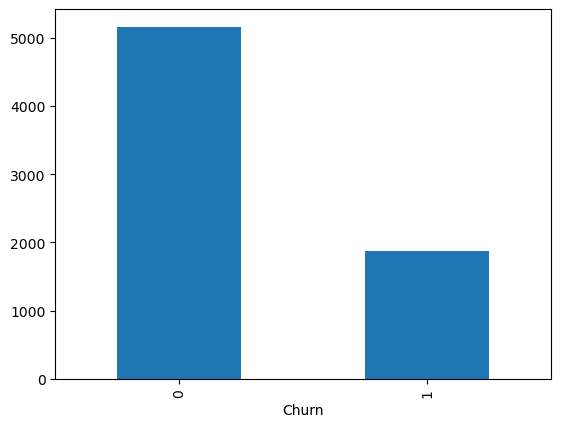

In [26]:
df['Churn'].value_counts().plot(kind= 'bar')

## Encoding Categorical features

In [29]:
# 1. Identify feature types
cat_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

num_cols = ['tenure','SeniorCitizen','MonthlyCharges', 'TotalCharges']

# 2. Pipelines for each type
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(handle_unknown='ignore', drop='first'))

# 3. Combine
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [30]:
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


## Build Predictive Model with Logistic Reression

In [31]:
# Final model pipeline
model = make_pipeline(preprocessor,
                      LogisticRegression(max_iter=1000))

# Train
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'SeniorCitizen',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [32]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)
print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.8044
Model Test Accuracy: 0.8053


## Extracting Feature Names and from Logistic Regression

In [48]:
# Get the fitted Logistic Regression model and preprocessor
lr_model = model.named_steps['logisticregression']
preprocessor = model.named_steps['columntransformer']

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Pair features with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
})

# Add a column for interpretability
coef_df['Importance'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Importance', ascending=False)


## Top Drivers of Churn (Positive Coefficients)

In [59]:
top_churn_risk = coef_df[coef_df['Coefficient'] > 0].head(10)
print("Top features that increase churn risk:")
print(top_churn_risk[['Feature', 'Coefficient']])


Top features that increase churn risk:
                                Feature  Coefficient
10     cat__InternetService_Fiber optic     1.107407
3                     num__TotalCharges     0.645508
28  cat__PaymentMethod_Electronic check     0.379150
21                 cat__StreamingTV_Yes     0.372407
9                cat__MultipleLines_Yes     0.362784
23             cat__StreamingMovies_Yes     0.344649
26            cat__PaperlessBilling_Yes     0.290931
17            cat__DeviceProtection_Yes     0.074264
29      cat__PaymentMethod_Mailed check     0.072700
1                    num__SeniorCitizen     0.072159


## Top Retention Features (Negative Coefficients)

In [60]:
top_retention_factors = coef_df[coef_df['Coefficient'] < 0].tail(10)
print("Top features that decrease churn risk (retention indicators):")
print(top_retention_factors[['Feature', 'Coefficient']])


Top features that decrease churn risk (retention indicators):
                                      Feature  Coefficient
18       cat__TechSupport_No internet service    -0.166359
20       cat__StreamingTV_No internet service    -0.166359
11                    cat__InternetService_No    -0.166359
16  cat__DeviceProtection_No internet service    -0.166359
14      cat__OnlineBackup_No internet service    -0.166359
12    cat__OnlineSecurity_No internet service    -0.166359
22   cat__StreamingMovies_No internet service    -0.166359
15                      cat__OnlineBackup_Yes    -0.129161
5                            cat__Partner_Yes    -0.025124
4                            cat__gender_Male    -0.024081


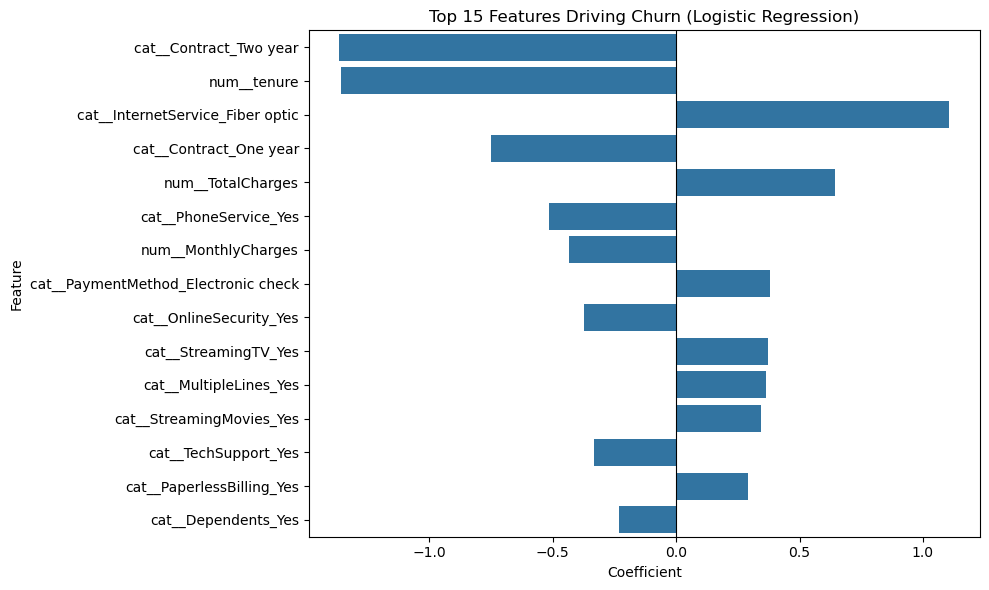

In [54]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title("Top 15 Features Driving Churn (Logistic Regression)")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [55]:
summary = coef_df[['Feature', 'Coefficient']].copy()
summary['Effect'] = summary['Coefficient'].apply(lambda x: 'Increases churn' if x > 0 else 'Reduces churn')
summary = summary.head(15)
print(summary)


                                Feature  Coefficient           Effect
25               cat__Contract_Two year    -1.364823    Reduces churn
0                           num__tenure    -1.357404    Reduces churn
10     cat__InternetService_Fiber optic     1.107407  Increases churn
24               cat__Contract_One year    -0.750068    Reduces churn
3                     num__TotalCharges     0.645508  Increases churn
7                 cat__PhoneService_Yes    -0.515337    Reduces churn
2                   num__MonthlyCharges    -0.434497    Reduces churn
28  cat__PaymentMethod_Electronic check     0.379150  Increases churn
13              cat__OnlineSecurity_Yes    -0.373187    Reduces churn
21                 cat__StreamingTV_Yes     0.372407  Increases churn
9                cat__MultipleLines_Yes     0.362784  Increases churn
23             cat__StreamingMovies_Yes     0.344649  Increases churn
19                 cat__TechSupport_Yes    -0.331578    Reduces churn
26            cat__P